# Autocomplete with PyTorch and RNNs on Colaboratory

Despite the recent very impressive advances in deep learning such as [GPT-2](https://openai.com/blog/better-language-models/), [BERT](https://ai.googleblog.com/2018/11/open-sourcing-bert-state-of-art-pre.html) or [Nvidia's GAN-powered face generator](https://medium.com/syncedreview/gan-2-0-nvidias-hyperrealistic-face-generator-e3439d33ebaf), the most influential article about deep learning for me personally is Andrej Karpathy‘s blog entry on [the unreasonable effectiveness of recurrent neural networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/). When I first read the article almost four years ago, I was amazed of how easily these networks produce text passages which resemble the basic style patterns of e.g. a work by Shakespeare or Linux source code. However, when I tried to train my own recurrent neural networks (RNN), I quickly noticed that without a state-of-art GPU, my neural network sounded more like a toddler than like Shakespeare. 

While buying your own GPU might be too expensive to just play around with a few deep learning examples and setting up an [AWS](https://aws.amazon.com/) instance might be too much of a hassle, there is an easy-to-use alternative: [Google Colaboratory](https://colab.research.google.com), a hosted Python development environment that features free GPU (and [TPU](https://cloud.google.com/tpu/)) usage. This tutorial can be opened in Colaboratory by simply clicking on the following badge:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/christophmark/pytorch-autocomplete/blob/master/pytorch-autocomplete.ipynb)

This tutorial aims to cover the complete workflow of a deep learning application, using only Google's computing and data storage resources. The content of this tutorial is inspried by Andrej Karpathy's examples: we will devise a recurrent neural network based on the deep learning framework `PyTorch` that is trained on topic-specific Python source code (e.g. code examples of `tensorflow` or `PyTorch` models) and subsequently serves as a helpful auto-complete function for coding.

To implement this application, we will learn to...
- connect the Colaboratoy notebook to Google Drive for data storage
- scrape training data from Github using automated search queries
- define a stacked LSTM recurrent neural network using PyTorch
- write a GPU-accelerated training routine with a live progress visualization
- integrate the trained model with the notebook environment to employ the auto-complete feature

**Acknowledgements**

Parts of the code in this tutorial have been taken from or are inspired by existing [GitHub](https://github.com/) projects & [StackOverflow](https://stackoverflow.com) answers:
- [neural_complete](https://github.com/kootenpv/neural_complete) by [Pascal van Kooten](https://github.com/kootenpv): A very similar project, based on `keras`/`tensorflow`. The webscraping code in this tutorial is adapted from *neural_complete*.
- [pytorch-charRNN](https://github.com/mcleonard/pytorch-charRNN) by [Mat Leonard](https://github.com/mcleonard): A PyTorch implementation of a character-wise RNN that served as the basis for the stacked LSTM network in this tutorial.
- The integration of the custom auto-complete function would not have been possible without [this hack](https://stackoverflow.com/questions/48187554/extended-information-for-an-ipython-custom-completer) by [Tarun Lalwani](https://stackoverflow.com/users/2830850/tarun-lalwani).

**Disclaimer**

Feel free to use this work for your own projects, it is licensed under the [MIT License](https://opensource.org/licenses/MIT):

<small><em>
> Copyright 2019 Christoph Mark

> Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

> The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

> THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.</em></small>

## 1. Google Colaboratory

Google Colaboratory is a hosted Python development environment based on [Jupyter notebooks](https://jupyter.org/). These notebooks allow to interweave structured text (using the [markdown syntax](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet)) and Python code. They and are particularly suited for prototyping new ideas, due to interactive code execution.

### 1.1 Activate GPU support

To activate GPU support, click on `Runtime > Change runtime type` int he notebook menu and choose `GPU` as the hardware accelerator. To check whether the GPU is available for computation, we import the deep learning framework [PyTorch](https://pytorch.org/):

In [0]:
import torch
torch.cuda.is_available()

True

If successful, the output of the cell above should print `True`. Note that Google Colaboratory also offers [TPU](https://cloud.google.com/tpu/) support. These *Tensor Processing Units* are specifically designed for machine learning tasks and may outperform conventional GPUs. While support for TPUs in PyTorch is still pending, [tensorflow](https://www.tensorflow.org/) models may benefit from using TPUs (see [this tutorial](https://colab.research.google.com/notebooks/tpu.ipynb)).

### 1.2 Useful commands

Within the notebook environment, you can not only execute Python code, but also bash commands by prepending a `!`. For example, you can install new Python packages via the package manager `pip`. Here, we just check the installed version of PyTorch:

In [0]:
!pip show torch

Name: torch
Version: 1.0.1.post2
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: UNKNOWN
Author: UNKNOWN
Author-email: UNKNOWN
License: UNKNOWN
Location: /usr/local/lib/python3.6/dist-packages
Requires: 
Required-by: torchvision, torchtext, fastai


Another useful command is `!kill -9 -1`. It will reset all running kernels and free up memory (including GPU memory). Furthermore, there are a few commands to have a closer look on the hardware spcifications, i.e. to get information about the installed CPU and GPU:

In [0]:
!lscpu |grep 'Model name'

Model name:          Intel(R) Xeon(R) CPU @ 2.30GHz


In [0]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-8b8a8acb-3932-fbb0-7bc9-b2ba7d05ac97)


In addition, you can check the available RAM and HDD memory:

In [0]:
!cat /proc/meminfo | grep 'MemAvailable'

MemAvailable:   12607400 kB


In [0]:
!df -h / | awk '{print $4}'

Avail
318G


Finally, one can execute the following command to get a live update on the GPU usage. This is useful to check how much of the GPU memory is in use to optimize the batchsize for training. Note that whenever the training routine in a notebook is still running, you need to execute this command in another Colaboratory notebook to get an instant response:

In [0]:
!nvidia-smi

Wed Apr 17 15:36:30 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P8    25W / 149W |     11MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### 1.3 Mount Google Drive

Another important prerequisite for training our neural network is a place to save checkpoints of the trained model and to store obtained training data. Colaboratory provides convenient access to Google Drive via the `google.colab` Python module. The following command will mount your Google Drive contents to the folder path `/content/gdrive` on the Colaboratory instance. For authentication, you have to click the generated link and paste the authorization code into the input field:



In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Now you can use conventional Python packages such as `os` or `sys` to create/delete/change files in your Google Drive folders just as if you were working on your local machine.

## 2. Getting training data

The application we want to develop in this tutorial is a classical example of character-based RNNs: The training data consists of text passages and the label (i.e. the target to train the network on) is a single character that follows the corresponding input text passage. The idea is that with enough input passages, the network will learn the structure of the text, i.e. it will learn words, sentence structure, punctuation - all from just looking at sequences of characters. We want to use Python code snippets as input sequences that are topic-specific, e.g. Python code related to PyTorch models or Matplotlib visualization code. Once we have trained our model on such a text corpus, we will use it to generate suggestions for incomplete code paragraphs - a function that is usually referred to as *auto-complete*.

The problem here is to get a large enough corpus of high-quality, topic-specific Python code. GitHub qualifies as such a source: first, the code hosted there is in most cases meant to be distributed to many people and should thus be of high quality (I'm a dreamer...). Second, GitHub is probably among the largest resources of source code available right now. In the following, we will use the [Python bindings](https://selenium-python.readthedocs.io/) of the Web Browser Automation tool [Selenium](https://www.seleniumhq.org/) to scrape the GitHub search results for suitable source code.

### 2.1 Webscraping with selenium

[Webscraping](https://en.wikipedia.org/wiki/Web_scraping) in general refers to the extraction of data from webpages. If you already know the URLs to query that contain the data in their HTML source code, the Python package `requests` can be used to retrieve the page source code. Scraping gets more complicated when multiple steps are required, e.g. navigating a login screen first, or in cases where data is displayed dynamically by Javascript. In the latter cases, we need to simulate the user of a browser that enters user credentials and clicks buttons, but in a fully automated fashion. Here, we use [Selenium](https://www.seleniumhq.org/) in combination with a [head-less](https://en.wikipedia.org/wiki/Headless_browser) Chrome browser to navigate GitHub.

The following commands install `selenium`, the `unidecode` package (needed to decode downloaded page sources), and the head-less browser on the Colaboratory instance.

In [0]:
!pip install selenium
!pip install unidecode

!apt-get update
!apt-get install chromium-chromedriver  

Now we are ready to let Selenium browse the GitHub search results and find links to source files that we will use as training data for our Recurrent Neural Network in the next section. As an exemplary search query, we will use 
```
torch "import torch.nn"
```
and further require Python files with a minimal file size of 30kB. Our training data thus consists of Python files that involve the `pytorch` package and the definition of neural networks. 

The code below automatically performs the GitHub-login (using your username and password in plain text, so BE CAREFUL SHARING THIS NOTEBOOK!!), search for the specified query and the navigate the result pages until no more results are found. On each results page, it harvests the links to the source files, which are then downloaded, cleaned (remove multiple newlines, comments, etc.), and added to the training corpus.

In case you do not want to scrape training data yourself, a preprocessed training data file can be downloaded [here](https://github.com/christophmark/pytorch-autocomplete/blob/master/data/github-pytorch-30000.txt).

In [0]:
import os
import re
import requests
import unidecode
import lxml.html
from time import sleep
import numpy as np
from selenium import webdriver
from tqdm import tqdm

In [0]:
# your GitHub username and password in plain-text
USERNAME = "XYZ" # ERASE BEFORE SHARING THIS NOTEBOOK!!!
PASSWORD = "XYZ" # ERASE BEFORE SHARING THIS NOTEBOOK!!!

# search query for GitHub code search
SEARCHQUERY = 'torch "import torch.nn"'

# minimal file size (bytes) to consider in code search
MINSIZE = 30000

# output file name to store all obtained data in
OUTNAME = 'github-pytorch-30000'

# directory to store output file in
OUTDIR = '/content/gdrive/My Drive/Colab Files/github-scraper'

In [0]:
# preprocessing function to clean up file contents (remove multiple newlines, comments, etc.)
def clean_content(x):
    x = unidecode.unidecode(x)
    x = re.sub('#.*$', '', x, flags=re.MULTILINE)
    x = re.sub("'''[\s\S]*?'''", '', x, flags=re.MULTILINE)
    x = re.sub('"""[\s\S]*?"""', '', x, flags=re.MULTILINE)
    x = re.sub('^[\t]+\n', '', x, flags=re.MULTILINE)
    x = re.sub('^[ ]+\n', '', x, flags=re.MULTILINE)
    x = re.sub('\n[\n]+', '\n\n', x, flags=re.MULTILINE)

    x += '\nEOF\n'
    return x

# create output directory if it does not exist
if not os.path.exists(OUTDIR):
    os.makedirs(OUTDIR)

# set options for Chrome driver used to scrape GitHub search
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

# initialize Chrome instance
driver = webdriver.Chrome('chromedriver', options=chrome_options)

# navigate the login screen of GitHub
driver.get("https://github.com/login")
driver.find_element_by_id("login_field").send_keys(USERNAME)
driver.find_element_by_id("password").send_keys(PASSWORD)
driver.find_element_by_id("password").submit()

# adjust the search query to include only Python source files
query = SEARCHQUERY+' filename:*.py size:>'+str(MINSIZE)+' language:Python'

# initialize variables used during scraping
links = set()
counts = []
counter = 1
data = ''

# initialize progress bar
pbar = tqdm(range(1, 101)) # GitHub search only supports 100 result pages
for i in pbar:
    try:
        # try not to annoy GitHub with too frequent requests
        sleep(np.random.uniform(2))
        
        # get search result page
        url = "https://github.com/search?p={}&q={}&ref=searchresults&type=Code&utf8=%E2%9C%93"
        driver.get(url.format(i, query))
        
        # get file links from search result page
        tree = lxml.html.fromstring(driver.page_source)
        page_links = list(set([x for x in tree.xpath('//a/@href') if "/blob/" in x and "#" not in x]))
        pbar.set_description("Page #{}. Found {} links.".format(i, len(page_links)))
        
        # if no results are found on three consecutive pages, we're done searching
        counts.append(len(page_links))
        if sum(counts[-3:]) == 0:
            break

        # visit file links and get source code
        for link in page_links:
            # leave out repetitive results
            if link not in links:
                try:
                    # try not to annoy GitHub with too frequent requests
                    sleep(np.random.uniform(2))
                    
                    # get and process source file contents
                    url = "https://github.com" + link
                    html = requests.get(url).text
                    tree = lxml.html.fromstring(html)
                    xpath = '//*[@class="blob-code blob-code-inner js-file-line"]'
                    content = "\n".join([x.text_content() for x in tree.xpath(xpath)])
                    data += clean_content(content)

                    pbar.set_description("Page #{}. File #{}. Total data size: {:.3f}MB".format(i, counter, len(data)/1e6))
                    counter += 1
                except:
                    pass
        
        # update set of found page links to detect duplicates
        links.update(page_links)
    
    # search can be stopped by interrupting kernel
    except KeyboardInterrupt:
        break

# save results
print('No more search results. Saving...')
with open(OUTDIR+'/'+OUTNAME+'.txt', 'w') as f:
    f.write(data)

Page #100. File #894. Total data size: 21.702MB: 100%|██████████| 100/100 [35:41<00:00, 22.52s/it]


No more search results. Saving...


Having scraped the training data (or downloaded the preprocessed training data), we may inspect parts of the data. As expected, we recognize some general Python syntax and commands, but also more specific imports and function definitions related to the Pytorch framework:

In [0]:
with open(OUTDIR+'/'+OUTNAME+'.txt') as f:
    data = ''.join(f.readlines())

print(data[:300])
print('\n--------------------------------------------------------------------------------\n')
print(data[100000:100300])
print('\n--------------------------------------------------------------------------------\n')
print(data[300000:300300])

from __future__ import print_function

import time

import matplotlib
import torch.nn as nn
import torch.nn.init as init

matplotlib.use('Agg')
import matplotlib.pyplot as plt
import os
import datetime
import pandas as pd
from torch.utils.data import TensorDataset

import torch.nn.parallel
from skle

--------------------------------------------------------------------------------

 dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
        dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
        dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
        dataset['Fare'] = dataset['Fare'].astype(int)

    for dataset in co

--------------------------------------------------------------------------------

 stride=stride, padding=padding,
                      bias=bias)
    return ret

class Forecaster(nn.Module):
    def __init__(self, num_seqs):
        super(Forecaster, self).__init__()

        num_filter = [8, 16, 16]
        ke

## 3. Deep recurrent neural networks with PyTorch

In contrast to many other deep learning tutorials here on Google Colaboratory that use the `tensorflow` framework, we will use Facebook's deep learning framework `PyTorch`. It is imported as `torch` and pre-installed on Colab-machines by default.

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display # live plotting

from datetime import datetime
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F

### 3.1 Working with text input

The aim of this project is to build a recurrent naurel network that can learn to write topic-specific Python code from series of individual characters. In contrast to word-based recurrent neural networks, this approach has the advantage that the vocabulary stays very small (the alphabet + other syntax characters), whereas word-based RNNs have to include common variable names and function names to generate meaningful output. The following functions do the preprocessing of character-based data, i.e. they encode the data (using [one-hot encoding](https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/)) and split them into batches for memory-efficient training of the RNN.

In [0]:
def get_chars(filepath):
    """
    Returns list of all characters present in a file
    """
    with open(filepath, 'r') as f:
        data = f.read()

    chars = list(set(data))
    return chars


def load_data(filepath, chars=None):
    """
    Opens a data file, determines the set of characters present in the file and encodes the characters.
    """
    with open(filepath, 'r') as f:
        data = f.read()

    if chars is None:
        chars = tuple(set(data))
    
    # lookup tables for encoding
    int2char = dict(enumerate(chars))
    char2int = {ch: ii for ii, ch in int2char.items()}
    
    # encoding
    encoded = np.array([char2int[ch] for ch in data])

    return chars, encoded


def one_hot_encode(arr, n_labels):
    """
    One-hot encoding for character-data
    """
    # Initialize the the encoded array
    one_hot = np.zeros((np.multiply(*arr.shape), n_labels), dtype=np.float32)

    # Fill the appropriate elements with ones
    one_hot[np.arange(one_hot.shape[0]), arr.flatten()] = 1.

    # Finally reshape it to get back to the original array
    one_hot = one_hot.reshape((*arr.shape, n_labels))

    return one_hot


def get_batches(arr, n_seqs, n_steps):
    """
    Batch generator that returns mini-batches of size (n_seqs x n_steps)
    """
    batch_size = n_seqs * n_steps
    n_batches = len(arr) // batch_size

    # always create full batches
    arr = arr[:n_batches * batch_size]
    
    # reshape
    arr = arr.reshape((n_seqs, -1))
    
    for n in range(0, arr.shape[1], n_steps):
        # features (sequence of characters)
        x = arr[:, n:n + n_steps]
        
        # targets (the next character after the sequence)
        y = np.zeros_like(x)
        try:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, n + n_steps]
        except IndexError:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, 0]
        yield x, y

### 3.2 Character-level RNN

The following code defines a basic multi-layer RNN with [LSTM](https://en.wikipedia.org/wiki/Long_short-term_memory) cells and [Dropout](https://en.wikipedia.org/wiki/Dropout_(neural_networks)) in `PyTorch`. Furthermore, we define functions to save checkpoints of the model during training and load these checkpoints again. These functions allow us to keep the best-trained model (according to the validation dataset) during the training procedure and to resume training after an interruption or to fine-tune a model on a second dataset.

In [0]:
class CharRNN(nn.Module):
    def __init__(self, tokens, n_hidden=256, n_layers=2, drop_prob=0.5):
        """
        Basic implementation of a multi-layer RNN with LSTM cells and Dropout.
        """
        super().__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden

        self.chars = tokens
        self.int2char = dict(enumerate(self.chars))
        self.char2int = {ch: ii for ii, ch in self.int2char.items()}

        self.dropout = nn.Dropout(drop_prob)
        self.lstm = nn.LSTM(len(self.chars), n_hidden, n_layers,
                            dropout=drop_prob, batch_first=True)
        self.fc = nn.Linear(n_hidden, len(self.chars))

    def forward(self, x, hidden):
        """
        Forward pass through the network
        """

        x, hidden = self.lstm(x, hidden)
        x = self.dropout(x)
        x = self.fc(x)

        return x, hidden

    def predict(self, char, hidden=None, device=torch.device('cpu'), top_k=None):
        """
        Given a character, predict the next character. Returns the predicted character and the hidden state.
        """
        with torch.no_grad():
            self.to(device)
            try:
                x = np.array([[self.char2int[char]]])
            except KeyError:
                return '', hidden

            x = one_hot_encode(x, len(self.chars))
            inputs = torch.from_numpy(x).to(device)

            out, hidden = self.forward(inputs, hidden)

            p = F.softmax(out, dim=2).data.to('cpu')

            if top_k is None:
                top_ch = np.arange(len(self.chars))
            else:
                p, top_ch = p.topk(top_k)
                top_ch = top_ch.numpy().squeeze()

            if top_k == 1:
                char = int(top_ch)
            else:
                p = p.numpy().squeeze()
                char = np.random.choice(top_ch, p=p / p.sum())

            return self.int2char[char], hidden


def save_checkpoint(net, opt, filename, train_history={}):
    """
    Save trained model to file.
    """
    checkpoint = {'n_hidden': net.n_hidden,
                  'n_layers': net.n_layers,
                  'state_dict': net.state_dict(),
                  'optimizer': opt.state_dict(),
                  'tokens': net.chars,
                  'train_history': train_history}

    with open(filename, 'wb') as f:
        torch.save(checkpoint, f)


def load_checkpoint(filename):
    """
    Load trained model from file.
    """
    with open(filename, 'rb') as f:
        checkpoint = torch.load(f, map_location='cpu')

    net = CharRNN(checkpoint['tokens'], n_hidden=checkpoint['n_hidden'], n_layers=checkpoint['n_layers'])
    net.load_state_dict(checkpoint['state_dict'])

    return net, checkpoint

### 3.3 Training

Training + validation loop. We implement early-stopping if validation loss has not decreased for 10 epochs.

In [0]:
plt.ion() # Allow live updates of plots

def train(net, data, epochs=10, n_seqs=10, n_steps=50, lr=0.001, clip=5, val_frac=0.1, device=torch.device('cpu'),
          name='checkpoint', early_stop=True, plot=True):
    """
    Training loop.
    """
    net.train() # switch into training mode
    opt = torch.optim.Adam(net.parameters(), lr=lr) # initialize optimizer
    criterion = nn.CrossEntropyLoss() # initialize loss function

    # create training and validation data
    val_idx = int(len(data) * (1 - val_frac))
    data, val_data = data[:val_idx], data[val_idx:]
    
    net.to(device) # move neural net to GPU/CPU memory
    
    min_val_loss = 10.**10 # initialize minimal validation loss
    train_history = {'epoch': [], 'step': [], 'loss': [], 'val_loss': []}

    n_chars = len(net.chars) # get size of vocabulary
    
    # main loop over training epochs
    for e in range(epochs):
        hidden = None # reste hidden state after each epoch
        
        # loop over batches
        for x, y in get_batches(data, n_seqs, n_steps):

            # encode data and create torch-tensors
            x = one_hot_encode(x, n_chars)
            inputs, targets = torch.from_numpy(x).to(device), torch.tensor(y, dtype=torch.long).to(device)
            
            # reset gradient information
            net.zero_grad()
            
            # generate network output
            output, hidden = net.forward(inputs, hidden)
            
            # compute loss
            loss = criterion(output.view(n_seqs * n_steps, n_chars), targets.view(n_seqs * n_steps))
            
            # compute gradients
            loss.backward()

            # gradient clipping to prevent exploding gradients
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            
            # optmize
            opt.step()

            # prevent backpropagating through the entire training history
            # by detaching hidden state and cell state
            hidden = (hidden[0].detach(), hidden[1].detach())
        
        # validation step is done without tracking gradients
        with torch.no_grad():
            val_h = None
            val_losses = []
            
            for x, y in get_batches(val_data, n_seqs, n_steps):
                x = one_hot_encode(x, n_chars)
                inputs, targets = torch.from_numpy(x).to(device), torch.tensor(y, dtype=torch.long).to(device)

                output, val_h = net.forward(inputs, val_h)
                
                val_loss = criterion(output.view(n_seqs * n_steps, n_chars), targets.view(n_seqs * n_steps))
                val_losses.append(val_loss.item())
            
            # compute mean validation loss over batches
            mean_val_loss = np.mean(val_losses)
            
            # track progress
            train_history['epoch'].append(e+1)
            train_history['loss'].append(loss.item())
            train_history['val_loss'].append(mean_val_loss)
        
        if plot:
            # create live plot of training loss and validation loss
            plt.clf()
            plt.plot(train_history['loss'], lw=2, c='C0')
            plt.plot(train_history['val_loss'], lw=2, c='C1')
            plt.xlabel('epoch')
            plt.title("{}   Epoch: {:.0f}/{:.0f}   Loss: {:.4f}   Val Loss: {:.4f}".format(
                datetime.now().strftime('%H:%M:%S'),
                e+1, epochs,
                loss.item(),
                mean_val_loss), color='k')
            display.clear_output(wait=True)
            display.display(plt.gcf())
        else:
            # print training progress
            print("{}   Epoch: {:.0f}/{:.0f}   Loss: {:.4f}   Val Loss: {:.4f}".format(
                datetime.now().strftime('%H:%M:%S'),
                e+1, epochs,
                loss.item(),
                mean_val_loss))
        
        # save model checkpoint if validation loss has decreased
        if mean_val_loss < min_val_loss:
            save_checkpoint(net, opt, name+'.net', train_history=train_history)
            min_val_loss = mean_val_loss
        
        # if validation loss has not decreased for the last 10 epochs, stop training
        if early_stop:
            if e - np.argmin(train_history['val_loss']) > 10:
                display.clear_output()
                print('Validation loss does not decrease further, stopping training.')
                break


Validation loss does not decrease further, stopping training.


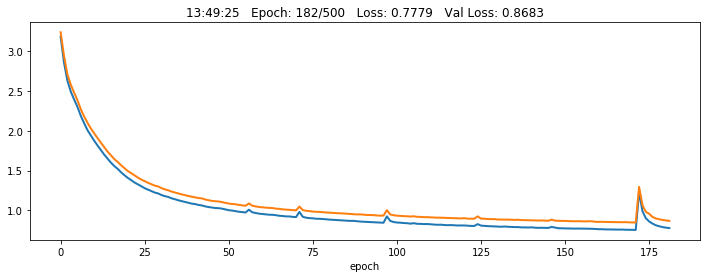

In [0]:
# use GPU if available, else use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# load data
chars, data = load_data('/content/gdrive/My Drive/Colab Files/github-scraper/github-pytorch-30000.txt')

# create RNN
net = CharRNN(chars, n_hidden=256, n_layers=3)

# train
plt.figure(figsize=(12, 4))
train(net, data, epochs=500, n_seqs=768, n_steps=512, lr=0.001, device=device, val_frac=0.1,
      name='/content/gdrive/My Drive/Colab Files/training-github-pytorch-30000', plot=True)


## 4. Application: topic-specific autocomplete

The goal is to use the trained network as an auto-completer when writing `PyTorch` code.

### 4.1 Sampling the trained network

A simple function to sample network output after priming the network with some Python code.

In [0]:
import re

def load_checkpoint(filename):
    with open(filename, 'rb') as f:
        checkpoint = torch.load(f, map_location='cpu')

    net = CharRNN(checkpoint['tokens'], n_hidden=checkpoint['n_hidden'], n_layers=checkpoint['n_layers'])
    net.load_state_dict(checkpoint['state_dict'])

    train_history = checkpoint['train_history']

    return net, train_history


def sample_lines(net, n_lines=3, prime='import', top_k=None, device='cpu', max_len=1000):
    net.to(device)
    net.eval()

    # First off, run through the prime characters
    chars = []
    h = None
    for ch in prime:
        char, h = net.predict(ch, h, device=device, top_k=top_k)

    chars.append(char)

    # Now pass in the previous character and get a new one
    l = 0
    for ii in range(max_len):
        char, h = net.predict(chars[-1], h, device=device, top_k=top_k)
        chars.append(char)
        if char == '\n':
            l += 1
            if l == n_lines:
                break

    return ''.join(chars)


def clean_string(x):
    x = re.sub('#.*$', '', x, flags=re.MULTILINE)
    x = re.sub("'''[\s\S]*?'''", '', x, flags=re.MULTILINE)
    x = re.sub('"""[\s\S]*?"""', '', x, flags=re.MULTILINE)
    x = re.sub('^[\t]+\n', '', x, flags=re.MULTILINE)
    x = re.sub('^[ ]+\n', '', x, flags=re.MULTILINE)
    x = re.sub('\n[\n]+', '\n\n', x, flags=re.MULTILINE)
    return x

net, _ = load_checkpoint('/content/gdrive/My Drive/Colab Files/training-github-pytorch-30000.net')

In [0]:
prime = 'import torch\n'

clean_prime = clean_string(prime)
print(sample_lines(net, 5, prime=clean_prime, top_k=3))

from torch.utils.data import Dataset, DataLoader

def conv(predicate_encoder, data, data_train_loader, train_loader, train_loader):
    plt.model()
    for item in range(0, n_layers):



### 4.2 Jupyter notebook magic

To make sampling more convenient, we define the magic command `%%sample`. If a code cell starts with this command, the remaining code in the cell is used as input for the network. The output of the cell upon execution are the next 20 lines of code as predicted by the network.

In [0]:
from IPython.core.magic import (register_line_magic, register_cell_magic,
                                register_line_cell_magic)

@register_cell_magic
def sample(line, prime):
    clean_prime = clean_string(prime)
    print(sample_lines(net, 20, prime=clean_prime, top_k=3))

In [0]:
%%sample
import matplotlib.pyplot as plt
import pandas as pd


import numpy as np

def state_dict(self, input):

    if self.start_size == 1:
        if isinstance(self, nn.Module):
            if self.dataset == 'critic':
                return self._cuda()
    def forward(self, input):
        if not isinstance(params):
            if self.training:
                input = self.activation(self.conv(x))
                save = module(state)

        if self.device:
            return self.__met___mask()
        if self.dict == 'test':
            target = self.transitions.compute(data)
            self.assertTrue(target.shape)




### 4.3 Juypter notebook integration

We define a custom completer within the Jupyter notebook environment. This injects code-completions from our trained network into the suggestions from the Jupyter editor when hitting `TAB`:

In [0]:
import IPython
import inspect

def charRNN_completer(self, t):
    # get code of current cell
    locals_caller = inspect.currentframe().f_back.f_back.f_back.f_back.f_locals
    code = locals_caller['code']
    cursor_pos = locals_caller['cursor_pos']
    
    # remove any reference to avoid leakages
    del locals_caller
    
    # create completions
    clean_prime = clean_string(code)
    completions = []
    
    completions.append(sample_lines(net, 1, prime=clean_prime, top_k=1))
    
    for i in range(3):
        completions.append(sample_lines(net, 1, prime=clean_prime, top_k=None))
        
    return completions

IPython.get_ipython().set_custom_completer(charRNN_completer)

In [0]:
class CharRNN(nn.Module):
    def __init__(self, tokens, n_